# Lesson 2.6:
# Publishing and Subscribing with the Simulation API

This tutorial introduces the Simulation API and how it can be used to run power system simulations, subscribe to measurement data, and publish equipment control commands.

__Learning Objectives:__

At the end of the tutorial, the user should be able to use the Simulation API to

* Create difference messages for controlling power system equipment
* Publish simulation input commands to a GridAPPS-D simulation
* Subscribe to the output messages from a GridAPPPS-D simulation using
    * a function definition
    * a class definition
    * the Simulation library methods
* Parse simulation output messages to obtain measurement values

## Getting Started

__1) Start GridAPPS-D Platform if not running:__

Before running any of the sample routines in this tutorial, it is first necessary to start the GridAPPS-D Platform and establish a connection to this notebook so that we can start passing calls to the API.

_Open the Ubuntu terminal and start the GridAPPS-D Platform if it is not running already:_

`cd gridappsd-docker`

~/gridappsd-docker$ `./run.sh -t develop`

_Once containers are running,_

gridappsd@[container]:/gridappsd$ `./run-gridappsd.sh`

__2) Start a simulation in the GridAPPS-D Viz:__

The Simulation API calls covered in this lesson need to be passed to an active simulation. For the purposes of this tutorial, we will use the GridAPPS-D Viz at [localhost:8080](http://localhost:8080/) to start a simulation of the IEEE 123 Node model with a 3600 sec simulation time. 

The steps for starting a simulation were covered in [Lesson 2.5, Section 3](Lesson%202.5.%20Simulation%20API%20-%20Running%20Simulations.ipynb#3.2.1.-"power_system_config":). 

After starting the simulation, paste the simulation_id into the code block below by clicking on the simulation_id. This will automatically copy the simulation_id to your computer's clipboard.

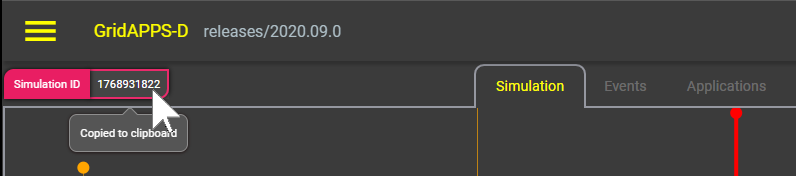

When your application is containerized in Docker and registered with the GridAPPS-D Platform using the docker-compose file, the simulation_id and feeder model mRID as passed as part of the application start call. For this notebook, that information needs to be copied and pasted into the first code block below. 

In [ ]:
# Establish connection to GridAPPS-D Platform:
from gridappsd import GridAPPSD

viz_simulation_id = "paste id here"

model_mrid = "_C1C3E687-6FFD-C753-582B-632A27E28507"

gapps = GridAPPSD(viz_simulation_id, "('localhost', 61613)", username='system', password='manager')

---
# Table of Contents

* [1. Introduction to the Simulation API](#1.-Introduction-to-the-Simulation-API)


* [2. Using the Simulation API](#2.-Using-the-Simulation-API)
    * [2.1. Specifying the Topic](#2.1.-Specifying-the-Topic)
    * [2.2. Structure of a Simulation Message](#2.2.-Structure-of-a-Simulation-Message)
    
    
* [3. Publishing to Simulation Input](#3.-Publishing-to-Simulation-Input)
    * [3.1. Topic to Publish to Simulation Input](#3.1.-Topic-to-Publish-to-Simulation-Input)
    * [3.2. Obtain Equipment Control mRIDs](#3.2.-Obtain-Equipment-Control-mRIDs)
    * [3.3. Format of a Difference Message](#3.3.-Format-of-a-Difference-Message)
    * [3.4. Using GridAPPSD-Python DifferenceBuilder](#3.4.-Using-GridAPPSD-Python-DifferenceBuilder)
    

* [4. Subscribing to Simulation Output](#4.-Subscribing-to-Simulation-Output)
    * [4.1. Specify the Topic](#4.1.-Specify-the-Topic)
    * [4.2. Obtain Measurement mRIDs](#4.2.-Obtain-Measurement-mRIDs)
    * [4.3. Structure of Simulation Output Message](#4.3.-Structure-of-Simulation-Output-Message)
    * [4.4. Subscribe using a Function Definition](#4.4.-Subscribe-using-a-Function-Definition)
    * [4.5. Subscribe using a Class Definition](#4.5.-Subscribe-using-a-Class-Definition)
    * [4.6. Using the GridAPPSD Python Simulation Library Shortcuts](#4.6.-Using-the-GridAPPSD-Python-Simulation-Library-Shortcuts)
    * [4.7. Comparison of Approaches](#4.7.-Comparison-of-Approaches)

---
# 1. Introduction to the Simulation API


The Simulation API is used for all actions related to a power system simulation. It is used to start, pause, restart, and stop a simulation from the command line or inside an application. It is all used to subscribe to measurements of equipment (such as line flows, loads, and DG setpoints) and the statuses of switches, capacitors, transformer taps, etc. It is also used to publish equipment control and other simulation input commands.

---
# 2. Using the Simulation API

## 2.1. Specifying the Topic

In the previous lessons all the queries passed to other APIs all used static `/queue/` channels to pass API calls to the GOSS message bus and the GridAPPS-D Platform. 

However, the Simulation API is used to communicate with a broad range of subscribers. The list of topics covered by the Simulation API cover both static `/queue/` and dynamic `/topic/` communication channel names. 

Extreme care is needed to use the correct topic. For a review of GridAPPS-D topics, see [Lesson 1.4.](Lesson%201.4.%20GridAPPS-D%20Topics.ipynb)

The correct topic for each Simulation API call will be provided in the corresponding section for each API task below.

## 2.2. Structure of a Simulation Message


Due to the wide range of tasks accomplished by the Simualtion API, there is no single message format that is used across all API Calls. 

Each message takes the form of a python dictionary or equivalent JSON script wrapped as a python string. 

The structure of each Simulation API call message will be provided in the corresponding section for each API task below.

[Return to Top](#Table-of-Contents)

---
# 3. Publishing to Simulation Input


## 3.1. Topic to Publish to Simulation Input

This is a dynamic `/topic/` communication channel that is best implemented by importing the GriAPPSD-Python library function for generating the correct topic. 

* `from gridappsd.topics import simulation_input_topic`
* `input_topic = simulation_input_topic(simulation_id)`

In [ ]:
from gridappsd.topics import simulation_input_topic

input_topic = simulation_input_topic(viz_simulation_id)

## 3.2. Obtain Equipment Control mRIDs

The mRIDs for controlling equipment are generally the same as those obtained using the `QUERY_OBJECT_TYPES` key with the PowerGrid Models API, which was covered in [Lesson 2.2, Section 4.4](Lesson%202.2.%20PowerGrid%20Models%20API%20-%20Using%20JSON%20Queries.ipynb#4.4.-Query-for-Object-Dictionary).

However, the control attributes for each class of equipment in CIM use a different naming convention than those for the object types. Below is a list of `"objectType"` used to query for mRIDs and the associated control attribute used in a difference message for each category of power system equipment:

* __Switches__
    * CIM Class Key: `"objectType": "LoadBreakSwitch"`
    * Control Attribute: `"attribute": "Switch.open"`
    * Values: `1` is open, `0` is closed

* __Capacitor Banks:__
    * CIM Class Key: `"objectType": "LinearShuntCompensator"`
    * Control Attribute: `"attribute": "ShuntCompensator.sections"`
    * Values: `0` is off/open, `1` is on/closed
    
* __Inverter-based DERs:__
    * CIM Class Key: `"objectType": "PowerElectronicsConnection"`
    * Control Attribute: `"attribute": "PowerElectronicsConnection.p"`
    * Control Attribute: `"attribute": "PowerElectronicsConnection.q"`
    * Values: number in Watts or VArs (not kW)
    
* __Synchronous Rotating (diesel) DGs:__
    * CIM Class Key: `"objectType": "SynchronousMachine"`
    * Control Attribute: `"attribute": "RotatingMachine.p"`
    * Control Attribute: `"attribute": "RotatingMachine.q"`
    * Values: number in Watts or VArs (not kW)
    
* __Regulating Transformer Tap:__
    * CIM Class Key: `"objectType": "RatioTapChanger"`
    * Control Attribute: `"attribute": "TapChanger.step"`
    * Values: integer value for tap step
    
Note on releases_2020.09.0: The query for RatioTapChanger is not supported in the PowerGrid Models API at the current time. A custom SPARQL query needs to be done, as illustrated in Lesson 2.3, Section X.XX

The example below shows a query to obtain the correct mRID for switch SW2 in the IEEE 123 node model:

In [ ]:
from gridappsd import topics as t

message = {
    "modelId": model_mrid,
    "requestType": "QUERY_OBJECT_DICT",
    "resultFormat": "JSON",
    "objectType": "LoadBreakSwitch"
}

response_obj = gapps.get_response(t.REQUEST_POWERGRID_DATA, message)
switch_dict = response_obj["data"]

# Filter to get mRID for switch SW2:
for index in switch_dict:
    if index["IdentifiedObject.name"] == 'sw2':
        sw_mrid = index["IdentifiedObject.mRID"]
        

[Return to Top](#Table-of-Contents)

## 3.3. Format of a Difference Message

The general format for a difference message is a python dictionary or equivalent JSON string that specifies the reverse difference and the forward difference, in compliance with the CIM standard:

The __reverse difference__ is the current status / value associated with the control attribute. It is a formatted as a list of dictionary constructs, with each dictionary specifying the equipment mRID associated with the CIM class keys above, the control attribute, and the current value of that control attribute. The list can contain reverse differences for multiple pieces of equipment.

The __forward difference__ is the desired new status / value associated with the control attribute. It is a formatted as a list of dictionary constructs, with each dictionary specifying the equipment mRID associated with the CIM class keys above, the control attribute, and the current value of that control attribute. The list can contain foward differences for multiple pieces of equipment.

```
message = {
  "command": "update",
  "input": {
      "simulation_id": "simulation id as string",
      "message": {
          "timestamp": epoch time number,
          "difference_mrid": "optional unique mRID for command logs",
          "reverse_differences": [{

                  "object": "first equipment mRID",
                  "attribute": "control attribute",
                  "value": current value
              },
              {

                  "object": "second equipment mRID",
                  "attribute": "control attribute",
                  "value": current value
              }
          ],
          "forward_differences": [{

                  "object": "first equipment mRID",
                  "attribute": "control attribute",
                  "value": new value
              },
              {

                  "object": "second equipment mRID",
                  "attribute": "control attribute",
                  "value": new value
              }
              ]
              }
      }
}

```

Note: The GridAPPS-D platform does not validate whether `"reverse_differences":` has the correct equipment control values for the current time. It is used just for compliance with the CIM standard.

[Return to Top](#Table-of-Contents)

## 3.4. Using GridAPPSD-Python `DifferenceBuilder`



The `DifferenceBuilder` class is a GridAPPSD-Python tool that can be used to automatically build the difference message with correct formatting. 

First import DifferenceBuilder from the GridAPPSD-Python Library and create an object that will be used to create the desired difference messages. 

In [ ]:
from gridappsd import DifferenceBuilder

my_diff_build = DifferenceBuilder(viz_simulation_id)

We then use two methods associated with the DifferenceBuilder object:
* `.add_difference(self, object_mrid, control_attribute, new_value, old_value)` -- Generates a correctly formatted difference message.
* `.get_message()` -- Saves the message as a python dictionary that can be published using gapps.send()

In [ ]:
my_diff_build.add_difference(sw_mrid, "Switch.open", 1, 0) # Open switch given by sw_mrid

message = my_diff_build.get_message()

The difference message is then published to the GOSS Message Bus and the Simulation API using the `.send()` method associated with the GridAPPS-D connection object.

In [ ]:
gapps.send(input_topic, message)

[Return to Top](#Table-of-Contents)

# 4. Subscribing to Simulation Output



## 4.1. Specify the Topic

This is a dynamic `/topic/` communication channel that is best implemented by importing the GriAPPSD-Python library function for generating the correct topic. 

In [ ]:
from gridappsd.topics import simulation_output_topic

output_topic = simulation_output_topic(viz_simulation_id)

[Return to Top](#Table-of-Contents)

## 4.2. Obtain Measurement mRIDs

The second step is to obtain the correct measurement mRIDs using the PowerGrid Models API, which was covered in [Lesson 2.2, Section 5.2](Lesson%202.2.%20PowerGrid%20Models%20API%20-%20Using%20JSON%20Queries.ipynb#5.2.-Querying-for-Measurements). 

These mRIDs will be needed to parse the simulation output message and filter it to just the desired set of measurements.

For the example below, we will be interested in only the measurement associated with switches, so we will use the PowerGrid Models API to query for the set of measurements associated with the CIM Class `LoadBreakSwitch`. We then will filter those values to just the mRIDs associated with each type of measurement.

In [ ]:
from gridappsd import topics as t

message = {
    "modelId": model_mrid,
    "requestType": "QUERY_OBJECT_MEASUREMENTS",
    "resultFormat": "JSON",
    "objectType": "LoadBreakSwitch"
}

response_obj = gapps.get_response(t.REQUEST_POWERGRID_DATA, message)

measurements_obj = response_obj["data"]

Pos_obj = [k for k in measurements_obj if k['type'] == 'Pos']
PNV_obj = [k for k in measurements_obj if k['type'] == 'PNV']
VA_obj = [k for k in measurements_obj if k['type'] == 'VA']
A_obj = [k for k in measurements_obj if k['type'] == 'Pos']


[Return to Top](#Table-of-Contents)

## 4.3. Structure of Simulation Output Message

The general format of the messages received by the Simulation API is a python dictionary with the following key-value pairs:

```
{         KEY                    VALUE
    "simulation_id" :           string,
    "message" : {
        "timestamp" :           epoch time number,
        "measurements" : {
            "meas mrid 1":{
                                "measurement_mrid": "meas mrid 1"
                                "magnitude": number,
                                "angle": number },
            "meas mrid 2":{
                                "measurement_mrid": "meas mrid 2"
                                "magnitude": number,
                                "angle": number },
                           .     
                           .
                           .
            "meas mrid n":{
                                "measurement_mrid": "meas mrid n"
                                "magnitude": number,
                                "angle": number },
    }
}
```

It is the responsibility of the application to parse and filter the message to obtain the desired measurements. 

[Return to Top](#Table-of-Contents)

## 4.4. Subscribe using a Function Definition

The first approach used to subscribe to measurements is to define a function with the correct set of arguments that is then passed to the `.subscribe()` method associated with the `GridAPPPSD()` object.

The function does not require a specific name, and is somewhat easier to define and use. However, the arguments of the function need to be named correctly for the GridAPPSD-Python library to process the simulation output correctly.

The format for the function definition is 

```
def mySubscribeFunction(header, message):
    # do something when receive a message
    # parse to get measurments
    # do something else
```

That function handle is then passed as an argument to the `.subscribe(topic, function_handle)` method:

__Note on Jupyter Notebook environment:__ In the examples below, the Jupyter Notebook environment does not update definitions of the subscription object or function definitions. As a result, it is necessary to restart the notebook kernel. The gapps connection object definition is included again for convenience in executing the notebook code blocks

In [ ]:
# Re-establish connection to GridAPPS-D Platform if Notebook Kernel was restarted:
from gridappsd import GridAPPSD, topics as t

viz_simulation_id = "paste id here"
model_mrid = "_C1C3E687-6FFD-C753-582B-632A27E28507"

gapps = GridAPPSD(viz_simulation_id, "('localhost', 61613)", username='system', password='manager')

# Re-run query for switch measurement mRIDs if Notebook Kernel was restarted
message = {
    "modelId": model_mrid,
    "requestType": "QUERY_OBJECT_MEASUREMENTS",
    "resultFormat": "JSON",
    "objectType": "LoadBreakSwitch"
}
response_obj = gapps.get_response(t.REQUEST_POWERGRID_DATA, message)
measurements_obj = response_obj["data"]

Note that the subscription function definition does not allow any additional parameters to be passed. The only allowed arguments are `header` and `message`. Any other parameters, such as measurement mRIDs will need to be defined as global variables:

In [ ]:
global Pos_obj # Define global python dictionary of position measurements
Pos_obj = [k for k in measurements_obj if k['type'] == 'Pos']

In [ ]:
def demoSubscription1(header, message):
    # Extract time and measurement values from message          
    timestamp = message["message"]["timestamp"]
    meas_value = message["message"]["measurements"]
    
    meas_mrid = list(meas_value.keys()) #obtain list of all mrid from message
    
    # Filter to measurements with value of zero
    open_switches = []
    for index in Pos_obj:
        if index["measid"] in meas_value:
            mrid = index["measid"]
            power = meas_value[mrid]
            if power["value"] == 0:
                open_switches.append(index["eqname"])
    
    # Print message to command line
    print("............")
    print("Number of open switches at time", timestamp, ' is ', len(set(open_switches)))

In [ ]:
gapps.subscribe(output_topic, demoSubscription1)

[Return to Top](#Table-of-Contents)

## 4.5. Subscribe using a Class Definition

The second approach used to subscribe to measurements is to define a class with `__init__` and `on_message` methods.

These methods specify 1) how your app would initialize variables and attributes at the start of the simulation and 2) how your app behaves when it receives various messages. 

__IMPORTANT!__ The GridAPPS-D Platform use the exact names and syntax for the methods:

* `__init__(self, simulation_id, gapps_object, optional_objects)` -- This method requires the simulation_id and GridAPPS-D connection object. It is also possible add other user-defined arguments, such as measurement mRIDs or other information required by your application.


* `on_message(self, headers, message)` -- This method allows the class to subscribe to simulation measurements. It also contains the core behavior of your application and how it responds to each type of message.

It is also possible to use the same class definition to subscribe to other topics, such as Simulation Logs. This is done by creating additional user-defined methods and then passing those methods to the `.subcribe()` method associated with the GridAPPS-D connection object. An example of how this is done is provided for subcribing to simulation logs in [Lesson 2.8, Section 4.3](Lesson%202.8.%20Logging%20API.ipynb#4.3.-Create-Subscription-Method)


### _This class definition is also the core code block of your application!_

The structure of the class is

```
class YourSimulationClassName(object):
    # Your documentation text here on what app does
    
    def __init__(self, simulation_id, gapps_obj, meas_obj, your_obj):
        # Instantiate class with specific initial state
        
        # Attributes required by Simulation API
        self._gapps = gapps_obj
        self._simulation_id = simulation_id
        
        # Attributes to publish difference measurements
        self.diff = DifferenceBuilder(simulation_id)
        
        # Custom attributes for measurements, custom info
        self.meas_mrid = meas_obj
        self.your_attribute1 = your_obj["key1"]
        self.your_attribute2 = your_obj["key2"]
        
    def on_message(self, headers, message):
        # What app should do when it receives a subscription message
        
        variable1 = message["message"]["key1"]
        variable2 = message["message"]["key2"]

        # Insert your custom app behavior here
        if variable1 == foo:
            bar = my_optimization_result
            
        # Insert your custom equipment commands here
        if variable2 == bar:
            self.diff.add_difference(object_mrid, control_attribute, new_value, old_value)
            
    def my_custom_method_1(self, headers, message):
        # Use extra methods to subscribe to other topics, such as simulation logs
        variable1 = message["key1"]
        variable2 = message["key2"]
        
    def my_custom_method_2(self, param1, param2):
        # Use extra methods as desired
        variable1 = foo
        variable2 = bar
        
        
```

__Note on Jupyter Notebook environment:__ In the examples below, the Jupyter Notebook environment does not update definitions of the subscription object or function definitions. As a result, it is necessary to restart the notebook kernel. The gapps connection object definition and query for measurement mRIDs is included again for convenience in executing the notebook code blocks

In [ ]:
# Re-establish connection to GridAPPS-D Platform if Notebook Kernel was restarted:
from gridappsd import GridAPPSD, topics as t

viz_simulation_id = "paste id here"
model_mrid = "_C1C3E687-6FFD-C753-582B-632A27E28507"

gapps = GridAPPSD(viz_simulation_id, "('localhost', 61613)", username='system', password='manager')

# Re-run query for switch measurement mRIDs if Notebook Kernel was restarted:
message = {
    "modelId": model_mrid,
    "requestType": "QUERY_OBJECT_MEASUREMENTS",
    "resultFormat": "JSON",
    "objectType": "LoadBreakSwitch"
}
response_obj = gapps.get_response(t.REQUEST_POWERGRID_DATA, message)
measurements_obj = response_obj["data"]

In [ ]:
class ApplicationDemo(object):
    # A simple class for interacting with simulation
    
    def __init__(self, simulation_id, gapps_obj, meas_obj):
        # Subscription callback from GridAPPSD object
        self._gapps = gapps_obj
        self._simulation_id = simulation_id
        self.meas_mrid = meas_obj
    
    def on_message(self, headers, message):
        
        # Extract time and measurement values from message          
        timestamp = message["message"]["timestamp"]
        meas_value = message["message"]["measurements"]
        
        # Filter measurement mRIDs to just position
        Pos_obj = [k for k in self.meas_mrid if k['type'] == 'Pos']
        
        # Filter to measurements with value of zero
        open_switches = []
        for index in Pos_obj:
            if index["measid"] in meas_value:
                mrid = index["measid"]
                power = meas_value[mrid]
                if power["value"] == 0:
                    open_switches.append(index["eqname"])
                    
        print("............")
        print("Number of open switches at time", timestamp, ' is ', len(set(open_switches)))
        

After defining the class, we create an object that will be passed to the `.subscribe(topic, object)` method associated with the GridAPPS-D connection object:

In [ ]:
demo_obj = ApplicationDemo(viz_simulation_id, gapps, measurements_obj)

gapps.subscribe(subscribe_topic, demo_obj) # only measurements simulation_output_topic

If we wish to subscribe to an additional topic (such as the Simulation Logs, a side communication channel between two different applications, or a communication with a particular service), we can define an additional method in the class (such as my_custom_method_1 in the pseudo-code above) and then pass it to to the `.subscribe(topic, object.method)` method associated with the GridAPPS-D connection object:

`gapps.subscribe(other_topic, demo_obj.my_custom_method_1)`

[Return to Top](#Table-of-Contents)

## 4.6. Using the GridAPPSD-Python Simulation Library Shortcuts

__Release_2020.09.0 Note:__ If the simulation was started from within the application by importing and using the `Simulation` library in GridAPPSD-Python (as shown in [Lesson 2.5, Section 3.3](Lesson%202.5.%20Simulation%20API%20-%20Running%20Simulations.ipynb#3.3.-Starting-the-Simulation)), then several shortcut functions can be used. These methods currently cannot interact with a simulation started from the Viz. This functionality will be added in a future release.


The GridAPPSD-Python library provides several shortcut methods can be used by importing the Simulation library for GridAPPS-D:

In [ ]:
import json
from gridappsd import GridAPPSD
from gridappsd.simulation import Simulation

gapps = GridAPPSD() # Create GridAPPS-D connection object

run123_config = json.load(open("Run123NodeFileSimAPI.json")) # Pull simulation config from saved file
    
simulation_obj = Simulation(gapps, run123_config) # Create Simulation object

simulation_obj.start_simulation() # Start Simulation

print("Successfully started simulation with simulation_id: ", simulation_obj.simulation_id)

The Simulation library provides four methods that can be used to define how the platform interacts with the simulation:

* `.add_ontimestep_callback(myfunction1)` -- Run the desired function on each timestep


* `.add_onmesurement_callback(myfunction2)` -- Run the desired function when a measurement is received. __Note on releases_2020.09.0: method name is misspelled in the library definition!!__


* `.add_oncomplete_callback(myfunction3)` -- Run the desired function when simulation is 


* `.add_onstart_callback(myfunction4)` -- Run desired function when simulation is started



Note that the measurement callback method returns just the measurements and timestamps without any of the message formatting used in the messages received by using the `gapps.subscribe(output_topic, object)` approach.

To use use these methods, we define a set of functions that determine the behavior of the application for each of the four types of callbacks listed above:

```
def onmeasurement(sim, timestamp, measurements):
    # Do something when app receives a measurement
    # Insert your custom app behavior here
    if measurements[object_mrid] == foo:
        bar = my_optimization_result
    
def oncomplete(sim):
    # Do something when simulation is complete
    # example: delete all variables, close files
```


__Note on Jupyter Notebook environment:__ In the examples below, the Jupyter Notebook environment does not update definitions of the subscription object or function definitions. As a result, it is necessary to restart the notebook kernel. The query to get measurement mRIDS is included again for convenience in executing the notebook code blocks

In [ ]:
# Re-run PowerGrid Models API query to get measurement mRIDS if Notebook Kernel was cleared between simulations
from gridappsd import topics as t

model_mrid = "_C1C3E687-6FFD-C753-582B-632A27E28507"
message = {
    "modelId": model_mrid,
    "requestType": "QUERY_OBJECT_MEASUREMENTS",
    "resultFormat": "JSON",
    "objectType": "LoadBreakSwitch"
}
response_obj = gapps.get_response(t.REQUEST_POWERGRID_DATA, message)
measurements_obj = response_obj["data"]
global Pos_obj
Pos_obj = [k for k in measurements_obj if k['type'] == 'Pos']


In [ ]:
def onmeasurement(sim, timestamp, measurements):
    # Filter to measurements with value of zero
    open_switches = []
    for index in Pos_obj:
        if index["measid"] in measurements:
            mrid = index["measid"]
            power = measurements[mrid]
            if power["value"] == 0:
                open_switches.append(index["eqname"])

    print("............")
    print("Number of open switches at time", timestamp, ' is ', len(set(open_switches)))

In [ ]:
simulation_obj.add_onmesurement_callback(onmeasurement)

[Return to Top](#Table-of-Contents)

## 4.7. Comparison of Approaches

Each approach has its advantages and disadvantages. 

* The function-based approach is simpler and easier to implement. However, any parameters obtained from other APIs or methods to be used inside the function currently need to be defined as global variables. 

* The class-based approach is more complex, but also more powerful. It provides greater flexibility in creating additional methods, arguments, etc.

* The Simulation Library-based approach is easiest, but only works currently for simulations started using the simulation_obj.start_simulation() method.

The choice of which approach is used depends on the personal preferences of the application developer.

[Return to Top](#Table-of-Contents)